# Short code to follow land cover change

1) Libraries to read geospatial tiff data
2) Functions to turn single band classified rasters to dataframes, compare them and obtaine raster with shown changes
3) Obtaining matrix of changes: which class turn to which in pixels and in percent of area

In [1]:
from osgeo import gdal

import rasterio as rio
from rasterio.plot import show
import rasterio.warp
import rasterio.shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import plotting_extent
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from rasterio import plot

import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

#maps legend (but it's better to open it in QGIS)
from matplotlib import colors
levels = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
clrs = ['navy','tomato','grey', 'forestgreen','yellowgreen','gold','purple','white' ] #'Open water','Settlements','Bare soil','Forest','Grassland', 'Agriculture', 'Swamp', 'Changes']
cmap, norm = colors.from_levels_and_colors(levels, clrs)

legend_labels={
    0: 'Open Water',
    1: 'Settlements',
    2: 'Bare Soil',
    3: 'Forest',
    4: 'Grassland',
    5: 'Agriculture',
    6: 'Swamps'}

In [2]:
def to_2d_array(x: np.ndarray)->np.ndarray: #misha grol functions
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])


#turn single band classified raster to dataframe
def get_table_data(raster:str):
    """
    Function takes path to the GeoTIFF raster file and return dataframe
    """
    with rio.open(raster, 'r+') as src:
        x = src.read()
        col_names = ['class']
        params = x[:len(x), ...]
        params = to_2d_array(x[:len(x), ...]) 
        df = pd.DataFrame(params.T, columns=col_names)
    return df

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1)#, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Map with changes is saved as GeoTIFF'

In [3]:
#get results of pixelwise comparasion of 2 rasters as df and as a map
def get_changes(raster1:str, raster2:str, return_change_map:bool=True):
    """
    Function takes two rasters and combines them. The outputs are dataframe with
    values from raster 1, values from raster 2, bool variable showing are they the same 
    or not, and new variable 'changed', which takes 0, if value in the same pixels of two 
    rasters are the same, and 1 if they are not
    """
    with rio.open(raster1, 'r+') as src:
        x = src.read()
    
    #getting table data
    df1 = get_table_data(raster1)
    df2 = get_table_data(raster2)
    
    #getting changes in pixel-based manner
    df = pd.DataFrame(df1['class'] == df2['class']) #true/false column whether pixel has changed
    df['old_class'] = df1['class'] #saving old map pixels
    df['new_class'] = df2['class'] #saving new map pixels
    df['changed_class'] = df['old_class'] # draft for changes column : if the class has not changed then old==new, showing old
    df.loc[df['old_class'] != df['new_class'], 'changed_class'] = 999 #if class has changed, for this pixel set ''999'' value

    #saving tiff with changes
    if return_change_map is True:
        changes = df['changed_class'] 
        reclassified = changes.values
        target_tile = reclassified.reshape((x.shape[1], x.shape[2]))
        output_mask=target_tile
        raster_output = 'change_map.tif'
        status = save_tif(raster_input=raster1, raster_output=raster_output, values=output_mask)
        print(status, 'with name', raster_output)
        return df
    else: return df

In [4]:
def get_transition_matrix(raster1:str, raster2:str):
    """
    Function takes two raster paths and return transition matrix in the pixel-based manner.
    REQUIRED: get_changes funciton, get_table_data function
    """
    comparison_df = get_changes(raster1, raster2, return_change_map=False) 
    change_df = comparison_df[comparison_df['class']==False]

    transition_pairs = pd.DataFrame() #getting all transition pairs
    for item in list(range(0,7)): #number of classes
        select_df = change_df[change_df[['old_class', 'new_class']].isin([item]).any(axis=1)] 
        select_count = select_df.groupby(['old_class', 'new_class']).size().reset_index().rename(columns={0:'pixel_sum'}) #counting number of transition pairs equal to number of specific transition pixels
        transition_pairs = pd.concat([transition_pairs, select_count]).drop_duplicates()
        transition_pairs = transition_pairs.reset_index().drop(columns='index')

    df_loss = pd.DataFrame(columns = list(range(0,7)), index=list(range(0,7))) #empty df with rows and colunms indicated by classes for loses 
    for item in list(range(0,7)):
        df_loss.loc[item,:] = -transition_pairs[transition_pairs[['old_class']].isin([item]).any(axis=1)].set_index('new_class')['pixel_sum'] #for loses negative values are used
        df_loss.fillna(0, inplace=True)

    df_gain = pd.DataFrame(columns = list(range(0,7)), index=list(range(0,7))) #empty df with rows and colunms indicated by classes for gains 
    for item in list(range(0,7)):
        df_gain.loc[item,:] = transition_pairs[transition_pairs[['new_class']].isin([item]).any(axis=1)].set_index('old_class')['pixel_sum'] #for gains positive values are used
        df_gain.fillna(0, inplace=True)

    transition_matrix = df_gain + df_loss #transition matrix
    transition_matrix.rename(columns = legend_labels, inplace=True) #setting names for columns from legend
    transition_matrix.rename(index=legend_labels, inplace=True) #setting names for rows from legend
    return transition_matrix   

# Pixel-based change detection 
1) getting dataset for analysis
2) getting TIFF file with new class corresponding to changes

In [5]:
fname = 'mask_2020.tiff'
fname2 = 'mask_2021.tiff'

# Visualisation

In [6]:
y_2020 = rio.open(fname).read()
y_2021 = rio.open(fname2).read()

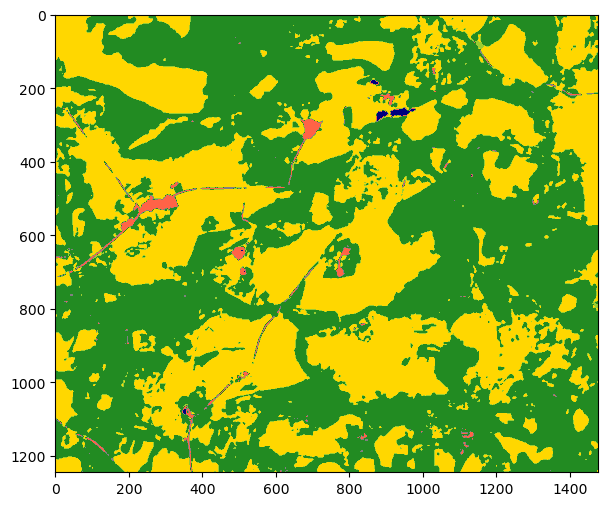

In [7]:
fig, ax = plt.subplots(figsize=(7,7))
raster_plot = show(y_2020, ax=ax, cmap=cmap, norm=norm)

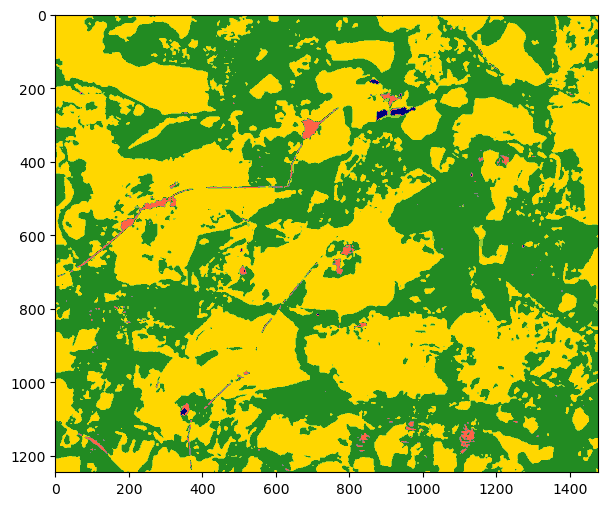

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
raster_plot = show(y_2021, ax=ax, cmap=cmap, norm=norm)


# Getting changes

In [9]:
comparison_data=get_changes(fname, fname2, return_change_map=False) 
comparison_data

,class,old_class,new_class,changed_class
0,True,5,5,5
1,True,5,5,5
2,True,5,5,5
3,True,5,5,5
4,True,5,5,5
...,...,...,...,...
1837615,True,3,3,3
1837616,False,3,5,999
1837617,True,5,5,5
1837618,True,5,5,5


# Visualisation of changes

In [10]:
fname_change = 'change_map.tif'
change_map = rio.open(fname_change).read()

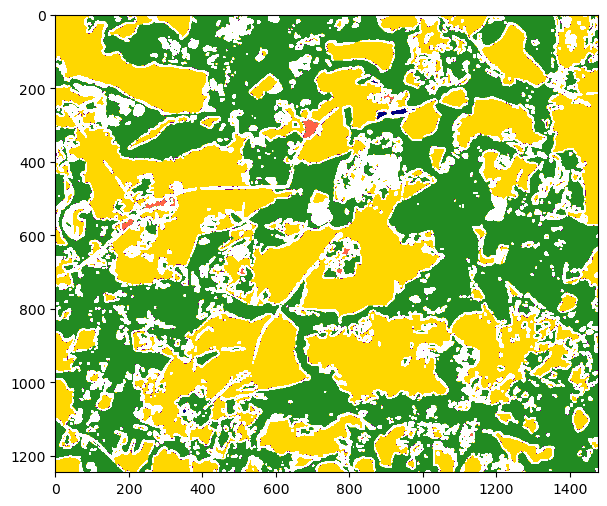

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
raster_plot = show(change_map, ax=ax, cmap=cmap, norm=norm) #changes are in white


# Matrix of changes

Here is the solution provided in the changes for each class as the transition from one class to the others in the way of loses (negative values) and gains (positive values). It could be further enriched by calculations in the area of each class according to the UTM zone.

In [12]:
get_transition_matrix(fname, fname2)

,Open Water,Settlements,Bare Soil,Forest,Grassland,Agriculture,Swamps
Open Water,0.0,26.0,10.0,314.0,-111.0,47.0,0.0
Settlements,-26.0,0.0,0.0,3072.0,-45.0,-5263.0,0.0
Bare Soil,-10.0,0.0,0.0,-16.0,-3.0,54.0,0.0
Forest,-314.0,-3072.0,16.0,0.0,-182.0,-122113.0,8.0
Grassland,111.0,45.0,3.0,182.0,0.0,571.0,0.0
Agriculture,-47.0,5263.0,-54.0,122113.0,-571.0,0.0,0.0
Swamps,0.0,0.0,0.0,-8.0,0.0,0.0,0.0


# 🗺